In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('./Brent_crude_oil.csv')
data.head()

,Date,Close,Open,High,Low,Vol,Changepercent,OVX,VIX,SMA,EMA,DEMA,MACD,Signal,RSI,CCI,Aroon_Up,Aroon_Down,TRIX
0,29-07-2024,79.78,81.30,81.74,79.36,132.25,-1.66,30.82,16.600000,79.227143,78.785521,79.338447,0.709319,0.827026,50.265393,44.513315,56,76,0.170974
1,26-07-2024,81.13,82.40,82.71,80.33,204.95,-1.51,29.77,16.389999,79.233571,79.098118,79.848238,0.837541,0.829129,50.238980,76.528035,96,72,0.168316
2,25-07-2024,82.37,81.58,82.53,80.09,332.16,0.81,26.49,18.459999,79.420000,79.534369,80.562557,1.027373,0.868778,56.945184,76.782026,92,68,0.172012
3,24-07-2024,81.71,81.46,82.23,80.93,298.20,0.86,26.85,18.040001,79.492857,79.824453,80.966956,1.111744,0.917371,52.753780,66.567962,88,64,0.177758
4,23-07-2024,81.01,82.25,82.79,80.51,384.32,-1.69,26.74,14.720000,79.400714,79.982526,81.109691,1.109337,0.955764,46.337308,54.683874,96,60,0.182490


In [2]:

# Convert 'Date' column to datetime and sort the dataset
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data = data.sort_values('Date')

In [3]:
# Use only the 'Close' prices for prediction
close_prices = data['Close'].values

In [4]:
# Split into train and test sets (80% train, 20% test)
train_size = int(len(close_prices) * 0.8)
train_data, test_data = close_prices[:train_size], close_prices[train_size:]

In [5]:
# ARIMA model fitting on training data
arima_order = (5, 1, 0)  # Example ARIMA(5,1,0), you can fine-tune it
arima_model = ARIMA(train_data, order=arima_order)
arima_fit = arima_model.fit()


In [6]:
# Forecast with ARIMA
arima_forecast = arima_fit.forecast(steps=len(test_data))

In [7]:

# Calculate residuals (difference between actual and ARIMA predictions)
arima_residuals_train = train_data - arima_fit.fittedvalues
arima_residuals_test = test_data - arima_forecast

In [8]:
# Normalize residuals for SVR
scaler = StandardScaler()
arima_residuals_train_scaled = scaler.fit_transform(arima_residuals_train.reshape(-1, 1))
arima_residuals_test_scaled = scaler.transform(arima_residuals_test.reshape(-1, 1))

In [9]:

# Create X and y for SVR (residuals prediction)
X_train_svr = np.arange(len(arima_residuals_train_scaled)).reshape(-1, 1)
X_test_svr = np.arange(len(arima_residuals_train_scaled), len(arima_residuals_train_scaled) + len(arima_residuals_test_scaled)).reshape(-1, 1)
y_train_svr = arima_residuals_train_scaled

In [10]:
# Train the SVR model on ARIMA residuals
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_svr, y_train_svr.ravel())

SVR()

In [11]:
# Predict residuals with SVR
svr_preds_residuals_scaled = svr_model.predict(X_test_svr)

# Inverse transform the SVR predicted residuals to the original scale
svr_preds_residuals = scaler.inverse_transform(svr_preds_residuals_scaled.reshape(-1, 1))

# Combine ARIMA forecast and SVR-predicted residuals
combined_preds = arima_forecast + svr_preds_residuals.ravel()

In [13]:
# Evaluate the model
rmse = root_mean_squared_error(test_data, combined_preds)
mae = mean_absolute_error(test_data, combined_preds)
mape = mean_absolute_percentage_error(test_data, combined_preds)

# Print evaluation metrics
print(f"Root Mean Squared Error (Chained ARIMA + SVR): {rmse}")
print(f"Mean Absolute Error (Chained ARIMA + SVR): {mae}")
print(f"Mean Absolute Percentage Error (Chained ARIMA + SVR): {mape}")

Root Mean Squared Error (Chained ARIMA + SVR): 5.105590346827685
Mean Absolute Error (Chained ARIMA + SVR): 4.1941362510758635
Mean Absolute Percentage Error (Chained ARIMA + SVR): 0.05083503104692415


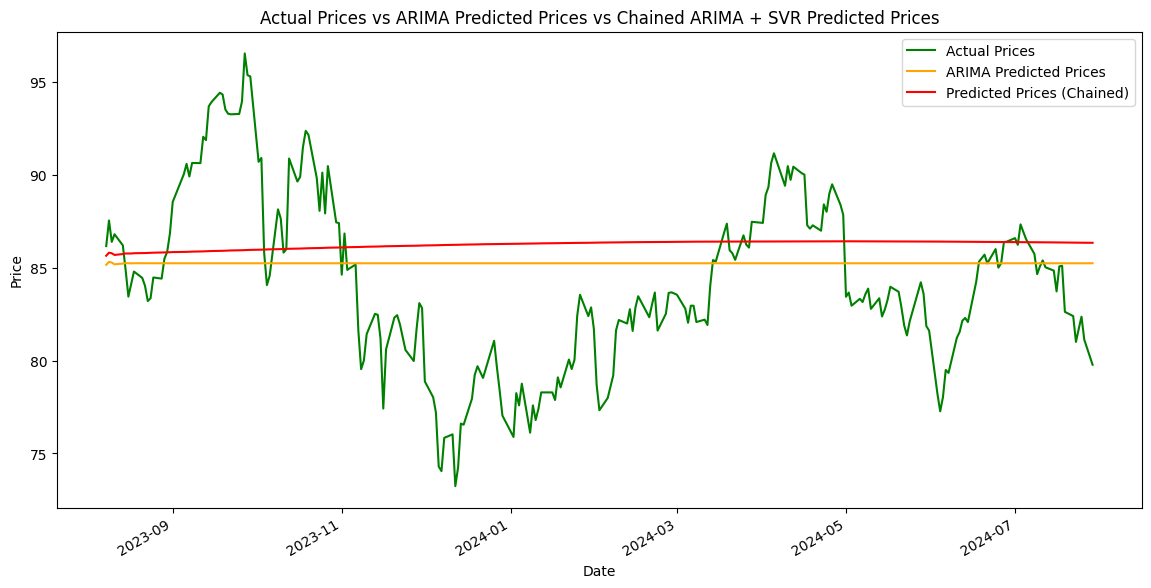

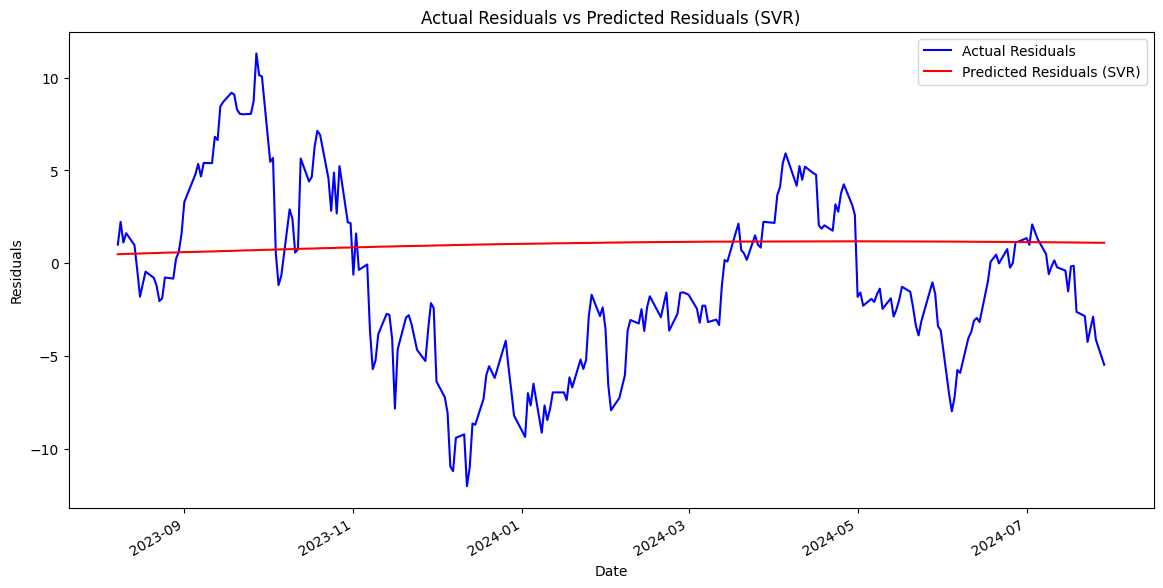

In [14]:

# Plot the actual vs predicted prices (ARIMA + SVR)
plt.figure(figsize=(14, 7))

# Plot actual prices (test data)
plt.plot(data['Date'].iloc[train_size:], test_data, label='Actual Prices', color='green')

# Plot ARIMA predicted prices
plt.plot(data['Date'].iloc[train_size:], arima_forecast, label='ARIMA Predicted Prices', color='orange')

# Plot predicted prices from the chained ARIMA + SVR model
plt.plot(data['Date'].iloc[train_size:], combined_preds, label='Predicted Prices (Chained)', color='red')

# Formatting
plt.gcf().autofmt_xdate()
plt.title("Actual Prices vs ARIMA Predicted Prices vs Chained ARIMA + SVR Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Plot the actual residuals vs predicted residuals (for SVR part)
plt.figure(figsize=(14, 7))

# Plot actual residuals (test data residuals)
plt.plot(data['Date'].iloc[train_size:], arima_residuals_test, label='Actual Residuals', color='blue')

# Plot predicted residuals from SVR
plt.plot(data['Date'].iloc[train_size:], svr_preds_residuals, label='Predicted Residuals (SVR)', color='red')

# Formatting
plt.gcf().autofmt_xdate()
plt.title("Actual Residuals vs Predicted Residuals (SVR)")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.legend()
plt.show()
